# Creating dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
DATADIR = '../datasets/Classification/Dataset - 3 dias/Images'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [3]:
def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            ## add images to training data with its label
            training_data.append([img_array, class_num])
    return training_data
            
training_data = create_training_data()
            

In [4]:
print(len(training_data))

1101


In [5]:
#mix data for better learning
import random
random.shuffle(training_data)

In [6]:
images = []
labels = []

for image, label in training_data:
    images.append(image)
    labels.append(label)

In [7]:
##saving dataset
import pickle
DATASET_PATH = "../datasets/Classification/Dataset - 3 dias/"

pickle_out = open(os.path.join(DATASET_PATH, "3_days_images.pickle"), "wb")
pickle.dump(images, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(DATASET_PATH, "3_days_labels.pickle"), "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()



# Creating classificatin model
##### Following this tutorial
       www.youtube.com/watch?v=WvoLTXIjBYU
##### Characteristics
 - Sequencial Model
 - Fully trained on this dataset

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os


#### Reading and preparing the dataset

In [9]:
import imutils
def pad_image(image, size_x, size_y):
    shape = image.shape
    res = []
    
    pad_image = np.zeros((size_x,size_y,3), np.uint8)
    
    if shape[0] > shape[1]:
        res = imutils.resize(image, height=size_x)
        res = center_image(res, pad_image)
    else:
        res = imutils.resize(image, width=size_y)
        res = center_image(res, pad_image)
    
    return res
    
def center_image(image, background):
    img_shape = image.shape
    bck_shape = background.shape
    
    x_diff = round((bck_shape[0] - img_shape[0])/2)
    y_diff = round((bck_shape[1] - img_shape[1])/2)
    
#     print(image.shape, background.shape, x_diff, y_diff)
    
    res = background.copy()
    
    res[x_diff:x_diff + img_shape[0],y_diff:y_diff + img_shape[1]] = image
    
    return res
        

In [10]:
images_raw = open(os.path.join(DATASET_PATH, "3_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "3_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 256

##### Padding Images in Memory

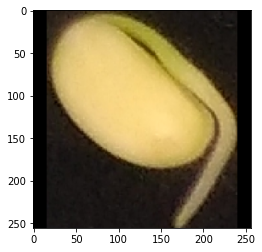

In [11]:
for i in range(len(images)):
    images[i] = pad_image(images[i], IMG_SIZE, IMG_SIZE)
    plt.imshow(images[i])

##### Labels one hot enconding

In [12]:
import pandas as pd

labels = pd.get_dummies(labels)
labels = pd.DataFrame.to_numpy(labels)

###### Train Test split

In [13]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

In [14]:
print(test_images.shape)

(221, 256, 256, 3)


##### Normalizing training images

In [15]:
train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

#### Creating the model


In [16]:
EPOCHS = 50
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = round( (1 - TRAIN_TEST_SPLIT) * train_images.shape[0] / 32)
print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

660.0 21


In [17]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(3, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

my_metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives(),]

opt = keras.optimizers.Adam(learning_rate=0.000005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)



In [18]:
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=TRAIN_TEST_SPLIT)

Epoch 1/50
32/32 [==============================] - 71s 2s/step - loss: 1.1288 - accuracy: 0.2492 - precision: 0.2704 - recall: 0.3077 - auc: 0.4422 - true_positives: 110.0909 - true_negatives: 413.0000 - false_positives: 298.2727 - false_negatives: 245.5455 - val_loss: 1.1091 - val_accuracy: 0.3364 - val_precision: 0.3333 - val_recall: 0.4091 - val_auc: 0.5044 - val_true_positives: 90.0000 - val_true_negatives: 260.0000 - val_false_positives: 180.0000 - val_false_negatives: 130.0000
Epoch 2/50
32/32 [==============================] - 68s 2s/step - loss: 1.1155 - accuracy: 0.3469 - precision: 0.3003 - recall: 0.3561 - auc: 0.4833 - true_positives: 129.7879 - true_negatives: 424.0303 - false_positives: 287.2424 - false_negatives: 225.8485 - val_loss: 1.0917 - val_accuracy: 0.4455 - val_precision: 0.3779 - val_recall: 0.4500 - val_auc: 0.5629 - val_true_positives: 99.0000 - val_true_negatives: 277.0000 - val_false_positives: 163.0000 - val_false_negatives: 121.0000
Epoch 3/50
32/32 [====

Epoch 18/50
32/32 [==============================] - 64s 2s/step - loss: 0.8803 - accuracy: 0.7766 - precision: 0.7496 - recall: 0.7761 - auc: 0.8507 - true_positives: 276.3636 - true_negatives: 622.5152 - false_positives: 88.7576 - false_negatives: 79.2727 - val_loss: 0.8786 - val_accuracy: 0.7500 - val_precision: 0.7399 - val_recall: 0.7500 - val_auc: 0.8427 - val_true_positives: 165.0000 - val_true_negatives: 382.0000 - val_false_positives: 58.0000 - val_false_negatives: 55.0000
Epoch 19/50
32/32 [==============================] - 67s 2s/step - loss: 0.8736 - accuracy: 0.7675 - precision: 0.7483 - recall: 0.7650 - auc: 0.8516 - true_positives: 274.6061 - true_negatives: 622.9394 - false_positives: 88.3333 - false_negatives: 81.0303 - val_loss: 0.8689 - val_accuracy: 0.7500 - val_precision: 0.7399 - val_recall: 0.7500 - val_auc: 0.8467 - val_true_positives: 165.0000 - val_true_negatives: 382.0000 - val_false_positives: 58.0000 - val_false_negatives: 55.0000
Epoch 20/50
32/32 [=======

Epoch 35/50
32/32 [==============================] - 53s 2s/step - loss: 0.7400 - accuracy: 0.7641 - precision: 0.7592 - recall: 0.7651 - auc: 0.8978 - true_positives: 277.7273 - true_negatives: 630.1818 - false_positives: 81.0909 - false_negatives: 77.9091 - val_loss: 0.7502 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8864 - val_true_positives: 165.0000 - val_true_negatives: 385.0000 - val_false_positives: 55.0000 - val_false_negatives: 55.0000
Epoch 36/50
32/32 [==============================] - 54s 2s/step - loss: 0.7261 - accuracy: 0.7707 - precision: 0.7676 - recall: 0.7729 - auc: 0.9069 - true_positives: 275.5758 - true_negatives: 628.3939 - false_positives: 82.8788 - false_negatives: 80.0606 - val_loss: 0.7446 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8882 - val_true_positives: 165.0000 - val_true_negatives: 385.0000 - val_false_positives: 55.0000 - val_false_negatives: 55.0000
Epoch 37/50
32/32 [=======

In [19]:
model.evaluate(test_images, test_labels, batch_size=1)

221/221 [==============================] - 19s 82ms/step - loss: 31.9866 - accuracy: 0.7692 - precision: 0.7589 - recall: 0.7692 - auc: 0.8107 - true_positives: 170.0000 - true_negatives: 388.0000 - false_positives: 54.0000 - false_negatives: 51.0000


[31.98656463623047,
 0.7692307829856873,
 0.7589285969734192,
 0.7692307829856873,
 0.8107379674911499,
 170.0,
 388.0,
 54.0,
 51.0]

#### Visualizing model data

In [20]:
import matplotlib.pyplot as plt

In [21]:
NUM_METRICS = len(my_metrics) + 1
METRICDIR = './metricas/classificacao/3_d/pre_trained_normalized_v2/'
SAVE = True

def plot_metric(metric_name, chart_name):
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if SAVE and not os.path.exists(METRICDIR):
        os.mkdir(METRICDIR)
    if SAVE:
        plt.savefig(os.path.join(METRICDIR, metric_name))
    plt.show()


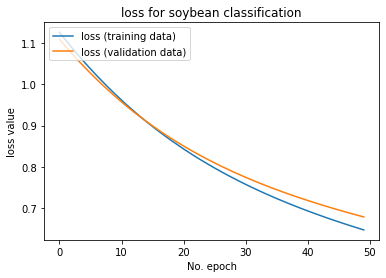

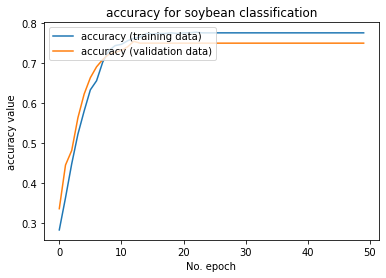

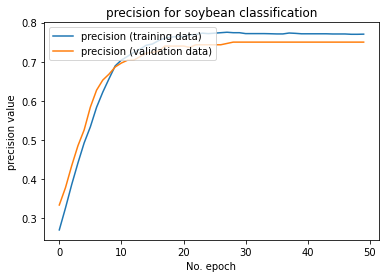

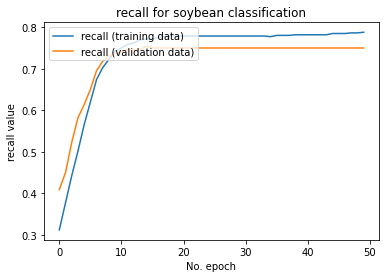

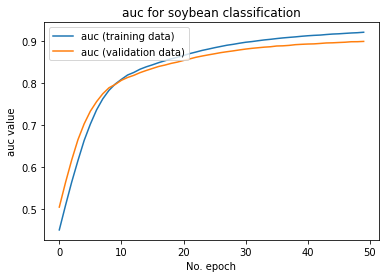

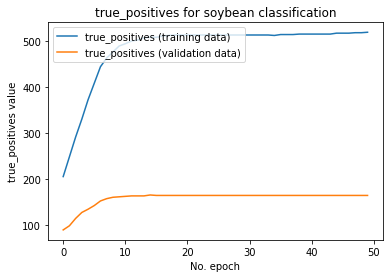

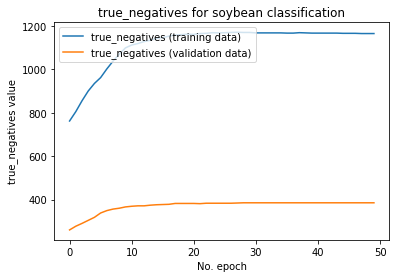

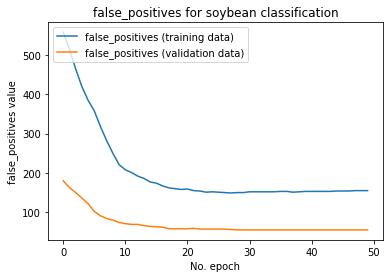

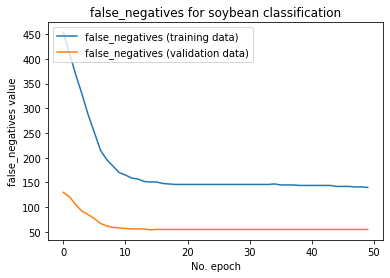

In [22]:
for metric in list(history.history.keys())[:NUM_METRICS]:
    plot_metric(metric, metric + " for soybean classification")


In [23]:
MODELDIR = os.path.join(METRICDIR, "model")
if SAVE and not os.path.exists(MODELDIR):
    os.mkdir(MODELDIR)
model.save(MODELDIR)

INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/pre_trained_normalized_v2/model/assets
